In [2]:
import pandas as pd

# Assuming this function needs to be defined:
def fahrenheit_to_celsius(temp_f):
    return (temp_f - 32) * 5/9

class SoyGDD:
    def __init__(self, daily_temp_df, time_column, min_temp_column, max_temp_column, celsius=True):
        self.daily_temp_df = daily_temp_df
        self.time_column = time_column
        self.min_temp_column = min_temp_column
        self.max_temp_column = max_temp_column
        self.celsius = celsius

        # Ensure the time column is of datetime type
        self.daily_temp_df[self.time_column] = pd.to_datetime(self.daily_temp_df[self.time_column])

        # Convert the temperature to Celsius if required
        if not self.celsius:
            self.daily_temp_df[self.min_temp_column] = self.daily_temp_df[self.min_temp_column].apply(fahrenheit_to_celsius)
            self.daily_temp_df[self.max_temp_column] = self.daily_temp_df[self.max_temp_column].apply(fahrenheit_to_celsius)
    
    def soy_gdd(self, start_date, end_date):
        start_date = pd.Timestamp(start_date)
        end_date = pd.Timestamp(end_date)

        date_mask = (self.daily_temp_df[self.time_column] >= start_date) & (self.daily_temp_df[self.time_column] <= end_date)
        masked_data = self.daily_temp_df.loc[date_mask].copy()

        gdd_values = []
        cumulative_gdd = 0

        for index, row in masked_data.iterrows():
            min_temp = max(row[self.min_temp_column], 10 if self.celsius else 50)
            max_temp = min(row[self.max_temp_column], 30 if self.celsius else 86)

            mean_temp = (min_temp + max_temp) / 2
            base_temp = 10 if self.celsius else 50
            gdd = max(mean_temp - base_temp, 0)

            gdd_values.append(gdd)
            cumulative_gdd += gdd

        masked_data['GDD'] = gdd_values
        masked_data['Cumulative_GDD'] = masked_data['GDD'].cumsum()

        return masked_data


In [3]:
data = pd.read_csv("Saintpaul_combined_data_NOAA.csv")

In [4]:
#Input data using SoyGDD instance for all 16 weather stations
soy_SP1951 = SoyGDD(data, time_column = 'time', min_temp_column = 'tmin',max_temp_column = 'tmax')

In [5]:
import pandas as pd

# Assuming 'data' DataFrame is already loaded with the necessary columns
# and the SoyGDD class is already defined as before

# Function to convert Celsius to Fahrenheit
def celsius_to_fahrenheit(celsius):
    return (celsius * 9/5) + 32

# Iterate over each year from 1951 to 2023
for year in range(1951, 2024):
    # Instantiate the SoyGDD class for the year
    soy_gdd_instance = SoyGDD(data, 'time', 'tmin', 'tmax')

    # Define the start and end dates for the year
    start_date = pd.to_datetime(f"{year}-01-01").date()
    end_date = pd.to_datetime(f"{year}-12-31").date()

    # Calculate the GDD for the year
    gdd_results = soy_gdd_instance.soy_gdd(start_date, end_date)

    # Convert GDD and Cumulative_GDD from Celsius to Fahrenheit
    gdd_results['GDD'] = gdd_results['GDD'].apply(celsius_to_fahrenheit)
    gdd_results['Cumulative_GDD'] = gdd_results['Cumulative_GDD'].apply(celsius_to_fahrenheit)

    # Print only the relevant columns (Time, GDD, and Cumulative_GDD)
    print(f"GDD Results for {year} (in Fahrenheit):\n", gdd_results[['time', 'GDD', 'Cumulative_GDD']], "\n")

GDD Results for 1951 (in Fahrenheit):
           time   GDD  Cumulative_GDD
0   1951-01-01  32.0       32.000000
1   1951-01-02  32.0       32.000000
2   1951-01-03  32.0       32.000000
3   1951-01-04  32.0       32.000000
4   1951-01-05  32.0       32.000000
..         ...   ...             ...
360 1951-12-27  32.0     2452.507812
361 1951-12-28  32.0     2452.507812
362 1951-12-29  32.0     2452.507812
363 1951-12-30  32.0     2452.507812
364 1951-12-31  32.0     2452.507812

[365 rows x 3 columns] 

GDD Results for 1952 (in Fahrenheit):
           time   GDD  Cumulative_GDD
365 1952-01-01  32.0       32.000000
366 1952-01-02  32.0       32.000000
367 1952-01-03  32.0       32.000000
368 1952-01-04  32.0       32.000000
369 1952-01-05  32.0       32.000000
..         ...   ...             ...
726 1952-12-27  32.0     2912.738281
727 1952-12-28  32.0     2912.738281
728 1952-12-29  32.0     2912.738281
729 1952-12-30  32.0     2912.738281
730 1952-12-31  32.0     2912.738281

[366 ro

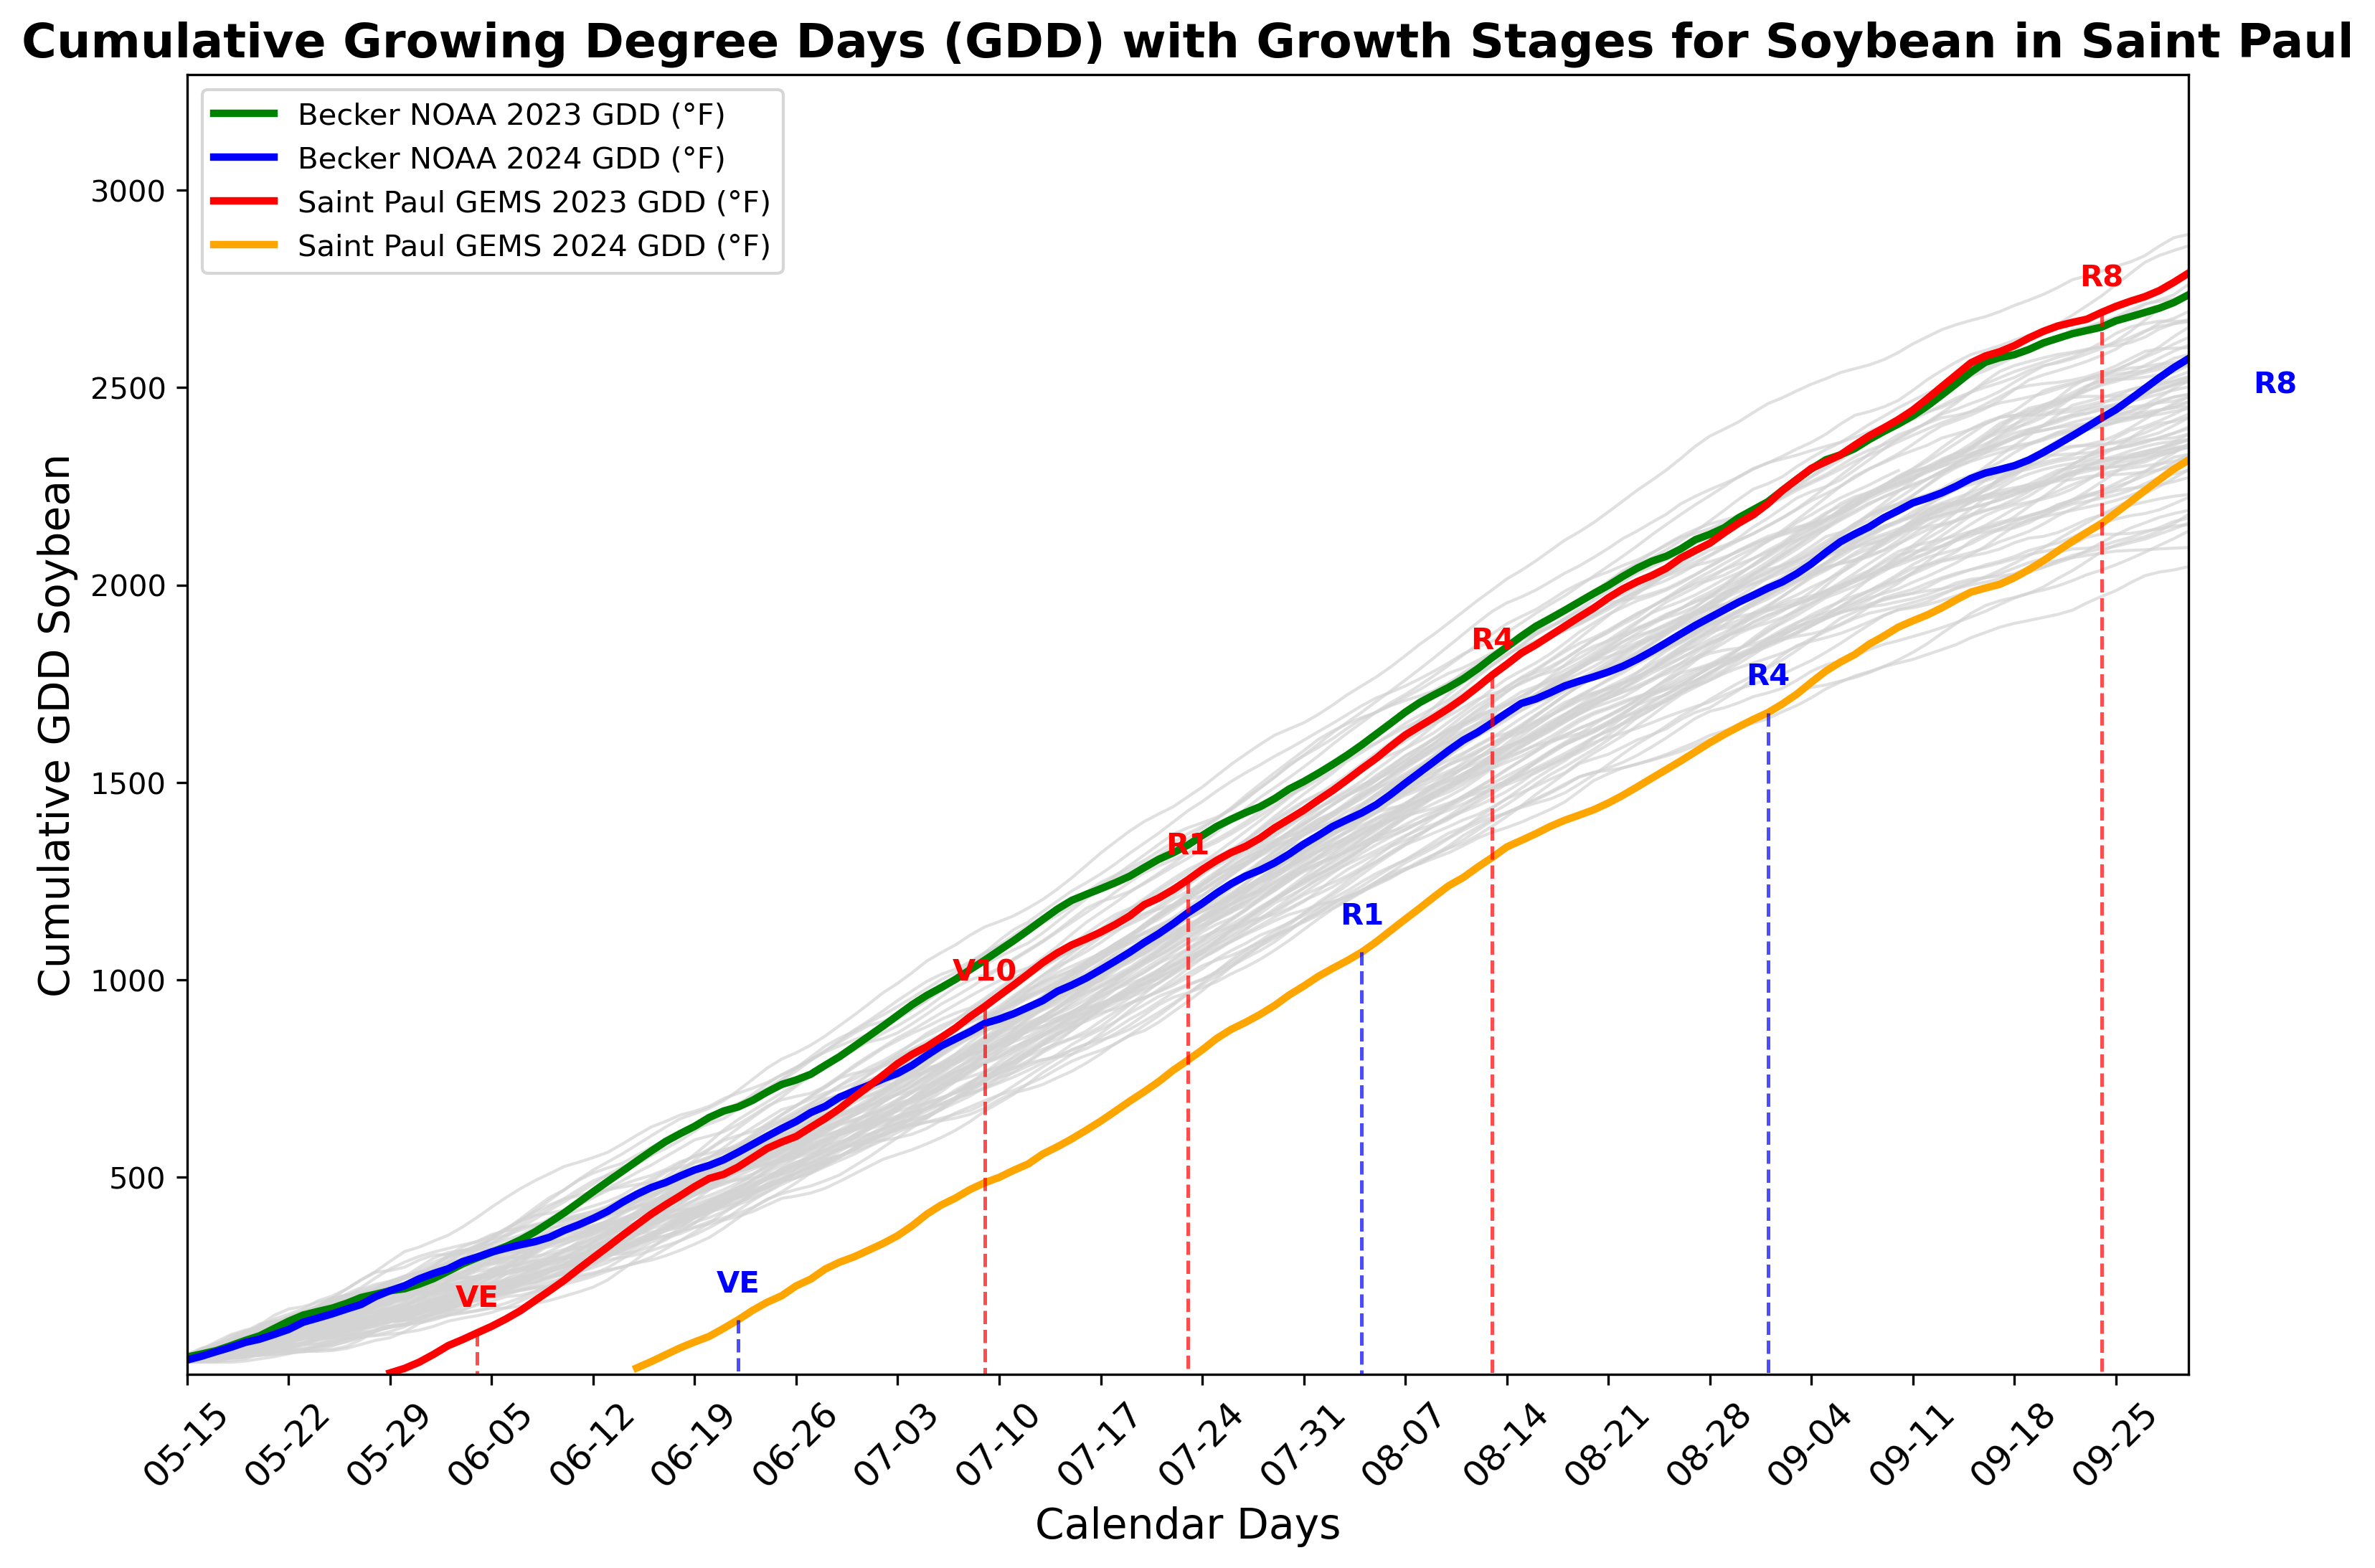

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load SaintPaul 2023 & 2024 GDD Data
file_path_2023 = "Soy_gdd_StPaulGEMS2023.csv"
file_path_2024 = "Soy_gdd_StPaulGEMS2024.csv"
growth_staging_2023_file = "Saint Paul 2023 Soy Growth Staging GEMS.csv"
growth_staging_2024_file = "Saint Paul 2024 Soy Growth Staging GEMS.csv"

SP_data_2023 = pd.read_csv(file_path_2023, parse_dates=['datetime'])
SP_data_2024 = pd.read_csv(file_path_2024, parse_dates=['datetime'])

# Load Growth Staging Data for 2023 & 2024
growth_staging_2023 = pd.read_csv(growth_staging_2023_file)
growth_staging_2024 = pd.read_csv(growth_staging_2024_file)

# Clean Column Names
growth_staging_2023.rename(columns=lambda x: x.strip(), inplace=True)
growth_staging_2024.rename(columns=lambda x: x.strip(), inplace=True)

# Convert Date Column to Proper Format
growth_staging_2023['Date'] = pd.to_datetime(growth_staging_2023['Date'] + '-2023', format='%d-%b-%Y', errors='coerce')
growth_staging_2024['Date'] = pd.to_datetime(growth_staging_2024['Date'] + '-2024', format='%d-%b-%Y', errors='coerce')

# Function to Get Mode of Growth Stage Without Errors
def get_mode(series):
    mode_values = series.mode()
    return mode_values[0] if not mode_values.empty else None

# Get Mode Growth Stage for Each Date (Handling Empty Cases)
growth_staging_mode_2023 = growth_staging_2023.groupby('Date')['Growth Stage'].agg(get_mode).reset_index()
growth_staging_mode_2024 = growth_staging_2024.groupby('Date')['Growth Stage'].agg(get_mode).reset_index()

# Merge Growth Staging Data with Becker GDD Data
SP_data_2023 = pd.merge(SP_data_2023, growth_staging_mode_2023, left_on='datetime', right_on='Date', how='left')
SP_data_2024 = pd.merge(SP_data_2024, growth_staging_mode_2024, left_on='datetime', right_on='Date', how='left')

# Function to Convert Celsius to Fahrenheit
def celsius_to_fahrenheit(celsius):
    return (celsius * 9/5) + 32

# Initialize Figure
fig, ax1 = plt.subplots(figsize=(12, 8), dpi=300)

# Define X-Axis Labels (Manual Month-Day Labels)
manual_dates = pd.date_range("2023-05-15", "2023-09-30").strftime('%m-%d').tolist()

# Plot Historical NOAA GDD (1951-2022) and NOAA 2023 & 2024
for year in range(1951, 2025):
    if year in [2000, 2016]:  # Skip specific years
        continue

    try:
        # Simulating data retrieval from a function (replace with actual data)
        soy_gdd_instance = SoyGDD(data, 'time', 'tmin', 'tmax')  # Assuming you have this function
        gdd_results = soy_gdd_instance.soy_gdd(pd.to_datetime(f"{year}-05-05").date(),
                                               pd.to_datetime(f"{year}-09-30").date())

        # Convert only historical GDD to Fahrenheit
        gdd_results['Cumulative_GDD'] = gdd_results['Cumulative_GDD'].apply(celsius_to_fahrenheit)
        gdd_results['Month_Day'] = gdd_results['time'].dt.strftime('%m-%d')

        # Highlight 2024 in Blue
        if year == 2024:
            ax1.plot(gdd_results['Month_Day'], gdd_results['Cumulative_GDD'], 
                     color='blue', linewidth=2.5, linestyle='solid', label="Becker NOAA 2024 GDD (°F)")

        # Highlight 2023 in Green
        elif year == 2023:
            ax1.plot(gdd_results['Month_Day'], gdd_results['Cumulative_GDD'], 
                     color='green', linewidth=2.5, linestyle='solid', label="Becker NOAA 2023 GDD (°F)")

        # Other years in Light Gray
        else:
            ax1.plot(gdd_results['Month_Day'], gdd_results['Cumulative_GDD'], 
                     color='lightgray', alpha=0.7, linewidth=1)

    except:
        continue

# Overlay SaintPaul 2023 & 2024 Data
SP_data_2023['Month_Day'] = SP_data_2023['datetime'].dt.strftime('%m-%d')
SP_data_2024['Month_Day'] = SP_data_2024['datetime'].dt.strftime('%m-%d')

# Plot Becker GEMS 2023 GDD (Red Solid Line)
ax1.plot(SP_data_2023['Month_Day'], SP_data_2023['Cumulative_GDD'], 
         color='red', linewidth=2.5, linestyle='solid', label='Saint Paul GEMS 2023 GDD (°F)')

# Plot Becker GEMS 2024 GDD (Orange Solid Line)
ax1.plot(SP_data_2024['Month_Day'], SP_data_2024['Cumulative_GDD'], 
         color='orange', linewidth=2.5, linestyle='solid', label='Saint Paul GEMS 2024 GDD (°F)')

# Annotate Key Growth Stages for 2023
for i, row in SP_data_2023.dropna(subset=['Growth Stage']).iterrows():
    if row['Growth Stage'] in ['VE', 'V7', 'V10', 'R1', 'R4', 'R8']:
        ax1.plot([row['Month_Day'], row['Month_Day']], [row['Cumulative_GDD'], 0], 
                 color='red', linestyle='--', linewidth=1.2, alpha=0.7)
        
        ax1.text(row['Month_Day'], row['Cumulative_GDD'] + 50, row['Growth Stage'], 
                 fontsize=10, ha='center', va='bottom', color='red', fontweight='bold')

# Add Growth Stage Annotations for 2024
for i, row in SP_data_2024.dropna(subset=['Growth Stage']).iterrows():
    if row['Growth Stage'] in ['VE', 'V7', 'V10', 'R1','R4', 'R8']:
        ax1.plot([row['Month_Day'], row['Month_Day']], [row['Cumulative_GDD'], 0], 
                 color='blue', linestyle='--', linewidth=1.2, alpha=0.7)  
        ax1.text(row['Month_Day'], row['Cumulative_GDD'] + 55, row['Growth Stage'], 
                 fontsize=10, ha='center', va='bottom', color='blue', fontweight='bold')

# Customize X-Axis Labels
ax1.set_xticks(range(0, len(manual_dates), 7))
ax1.set_xticklabels(manual_dates[::7], rotation=45, fontsize=12)

# Customize Y-Axis and Labels
ax1.set_xlabel('Calendar Days', fontsize=14)
ax1.set_ylabel('Cumulative GDD Soybean', fontsize=14, color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Set Limits
ax1.set_xlim(0, len(manual_dates) - 1)
ax1.set_ylim(bottom=1)

# Add Legends
ax1.legend(loc="upper left")

# Add Title
plt.title('Cumulative Growing Degree Days (GDD) with Growth Stages for Soybean in Saint Paul', fontsize=16, weight='bold')

# Show the Plot
plt.show()


/tmp/ipykernel_86/2326247347.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.daily_temp_df[self.time_column] = pd.to_datetime(self.daily_temp_df[self.time_column])
/tmp/ipykernel_86/2326247347.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.daily_temp_df[self.time_column] = pd.to_datetime(self.daily_temp_df[self.time_column])
/tmp/ipykernel_86/2326247347.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

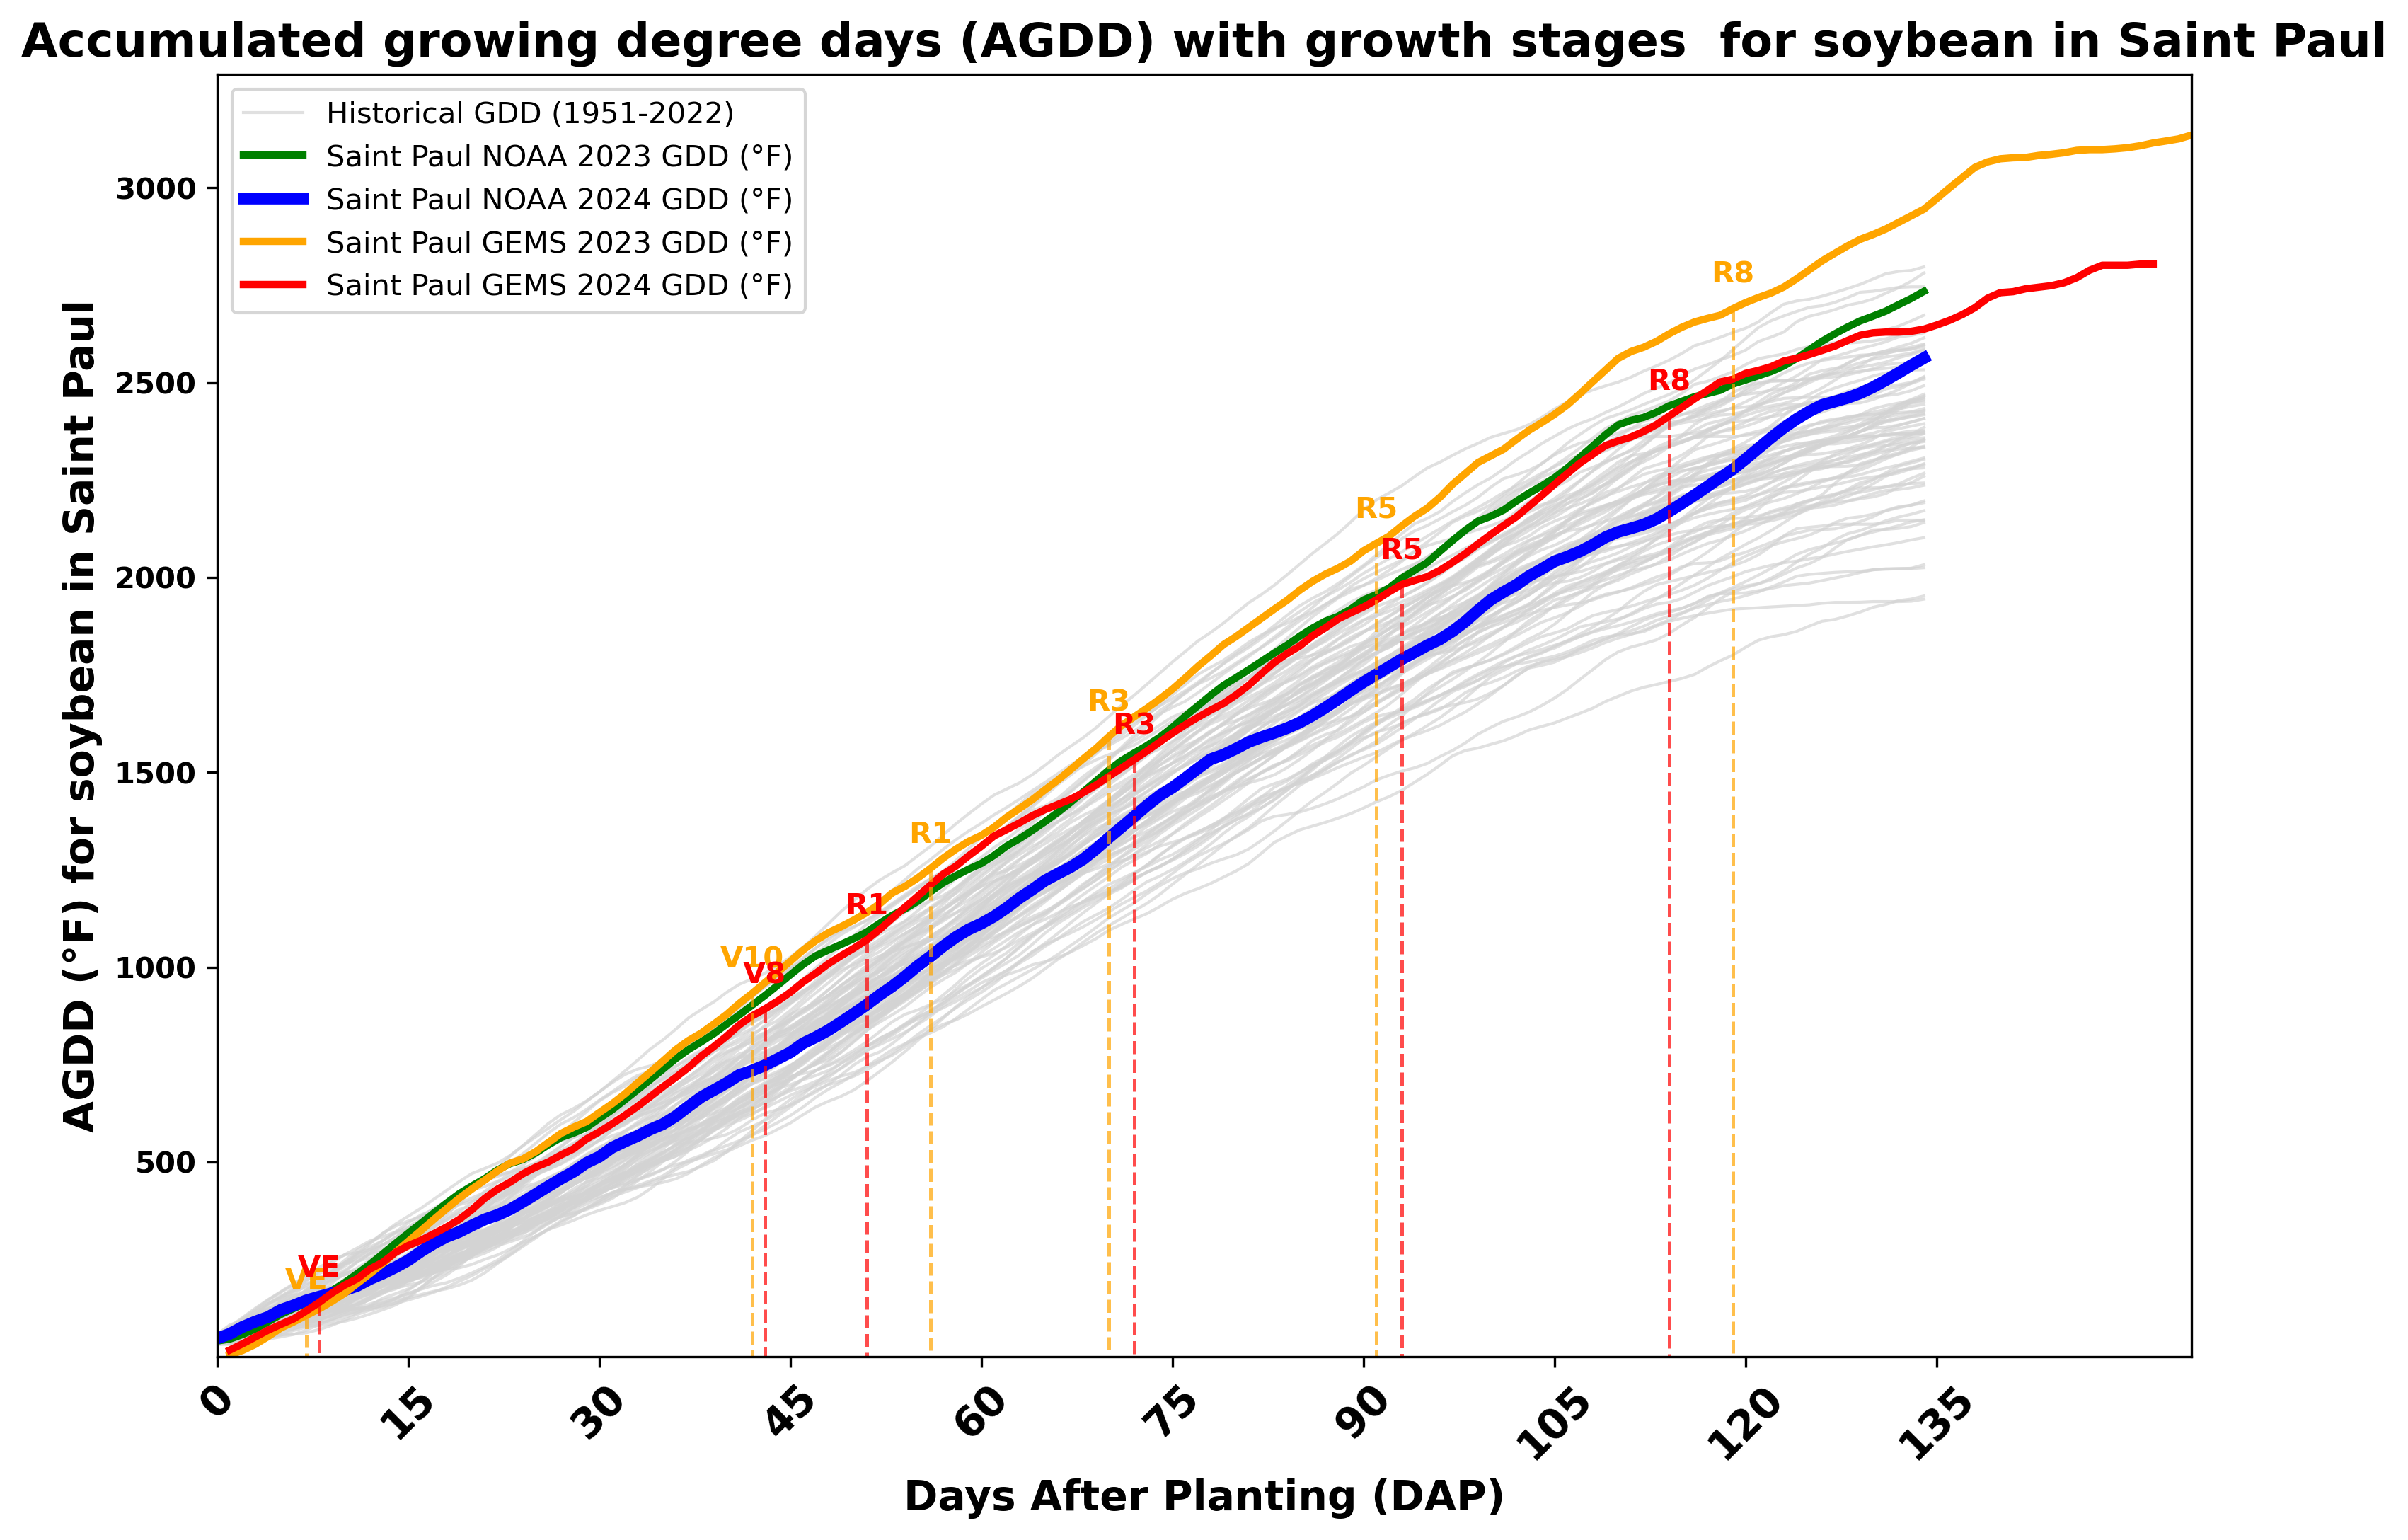

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load SaintPaul 2023 & 2024 GDD Data
file_path_2023 = "Soy_gdd_StPaulGEMS2023.csv"
file_path_2024 = "Soy_gdd_StPaulGEMS2024.csv"
growth_staging_2023_file = "Saint Paul 2023 Soy Growth Staging GEMS.csv"
growth_staging_2024_file = "Saint Paul 2024 Soy Growth Staging GEMS.csv"

SP_data_2023 = pd.read_csv(file_path_2023, parse_dates=['datetime'])
SP_data_2024 = pd.read_csv(file_path_2024, parse_dates=['datetime'])

# Define planting dates for DAP calculation
planting_date_2023 = pd.Timestamp("2023-05-18")
planting_date_2024 = pd.Timestamp("2024-06-04")

# Compute Days After Planting (DAP)
SP_data_2023['DAP'] = (SP_data_2023['datetime'] - planting_date_2023).dt.days
SP_data_2024['DAP'] = (SP_data_2024['datetime'] - planting_date_2024).dt.days

# Load Growth Staging Data for 2023 & 2024
growth_staging_2023 = pd.read_csv(growth_staging_2023_file)
growth_staging_2024 = pd.read_csv(growth_staging_2024_file)

# Clean Column Names
growth_staging_2023.rename(columns=lambda x: x.strip(), inplace=True)
growth_staging_2024.rename(columns=lambda x: x.strip(), inplace=True)

# Convert Date Column to Proper Format
growth_staging_2023['Date'] = pd.to_datetime(growth_staging_2023['Date'] + '-2023', format='%d-%b-%Y', errors='coerce')
growth_staging_2024['Date'] = pd.to_datetime(growth_staging_2024['Date'] + '-2024', format='%d-%b-%Y', errors='coerce')

# Function to Get Mode of Growth Stage Without Errors
def get_mode(series):
    mode_values = series.mode()
    return mode_values[0] if not mode_values.empty else None

# Get Mode Growth Stage for Each Date (Handling Empty Cases)
growth_staging_mode_2023 = growth_staging_2023.groupby('Date')['Growth Stage'].agg(get_mode).reset_index()
growth_staging_mode_2024 = growth_staging_2024.groupby('Date')['Growth Stage'].agg(get_mode).reset_index()

# Merge Growth Staging Data with Becker GDD Data
SP_data_2023 = pd.merge(SP_data_2023, growth_staging_mode_2023, left_on='datetime', right_on='Date', how='left')
SP_data_2024 = pd.merge(SP_data_2024, growth_staging_mode_2024, left_on='datetime', right_on='Date', how='left')

# Function to Convert Celsius to Fahrenheit
def celsius_to_fahrenheit(celsius):
    return (celsius * 9/5) + 32

# Initialize Figure
fig, ax1 = plt.subplots(figsize=(12, 8), dpi=300)

# Plot All Historical NOAA GDD Lines (1951-2022) in Light Gray
gray_label_added = False  # Ensure only one label is included

for year in range(1951, 2025):  # Includes 2023 & 2024 to be plotted separately
    try:
        # Simulating data retrieval from a function (replace with actual data)
        soy_gdd_instance = SoyGDD(data, 'time', 'tmin', 'tmax')  # Assuming you have this function
        gdd_results = soy_gdd_instance.soy_gdd(pd.to_datetime(f"{year}-05-19").date(),
                                               pd.to_datetime(f"{year}-09-30").date())

        # Convert GDD to Fahrenheit
        gdd_results['Cumulative_GDD'] = gdd_results['Cumulative_GDD'].apply(celsius_to_fahrenheit)
        gdd_results['DAP'] = (gdd_results['time'] - pd.to_datetime(f"{year}-05-19")).dt.days

        # Plot Historical Data (1951-2022) in Light Gray
        if year < 2023:
            if not gray_label_added:
                ax1.plot(gdd_results['DAP'], gdd_results['Cumulative_GDD'], 
                         color='lightgray', alpha=0.7, linewidth=1, label="Historical GDD (1951-2022)")
                gray_label_added = True
            else:
                ax1.plot(gdd_results['DAP'], gdd_results['Cumulative_GDD'], 
                         color='lightgray', alpha=0.7, linewidth=1)

        # Highlight NOAA 2023 in Green
        elif year == 2023:
            ax1.plot(gdd_results['DAP'], gdd_results['Cumulative_GDD'], 
                     color='green', linewidth=2.5, linestyle='solid', label="Saint Paul NOAA 2023 GDD (°F)")

        # Highlight NOAA 2024 in Blue
        elif year == 2024:
            ax1.plot(gdd_results['DAP'], gdd_results['Cumulative_GDD'], 
                     color='blue', linewidth= 4, linestyle='solid', label="Saint Paul NOAA 2024 GDD (°F)")

    except Exception as e:
        print(f"Error processing year {year}: {e}")
        continue

# Plot Becker GEMS 2023 GDD (Red Solid Line)
ax1.plot(SP_data_2023['DAP'], SP_data_2023['Cumulative_GDD'], 
         color='orange', linewidth=2.5, linestyle='solid', label='Saint Paul GEMS 2023 GDD (°F)')

# Plot Becker GEMS 2024 GDD (Orange Solid Line)
ax1.plot(SP_data_2024['DAP'], SP_data_2024['Cumulative_GDD'], 
         color='red', linewidth=2.5, linestyle='solid', label='Saint Paul GEMS 2024 GDD (°F)')

# Annotate Key Growth Stages for 2023
for i, row in SP_data_2023.dropna(subset=['Growth Stage']).iterrows():
    if row['Growth Stage'] in ['VE', 'V10','R1','R3', 'R5', 'R8']:
        ax1.plot([row['DAP'], row['DAP']], [row['Cumulative_GDD'], 0], 
                 color='orange', linestyle='--', linewidth=1.2, alpha=0.7)
        
        ax1.text(row['DAP'], row['Cumulative_GDD'] + 50, row['Growth Stage'], 
                 fontsize=10, ha='center', va='bottom', color='orange', fontweight='bold')

# Annotate Key Growth Stages for 2024
for i, row in SP_data_2024.dropna(subset=['Growth Stage']).iterrows():
    if row['Growth Stage'] in ['VE', 'V8', 'R1', 'R3', 'R5', 'R8']:
        ax1.plot([row['DAP'], row['DAP']], [row['Cumulative_GDD'], 0], 
                 color='red', linestyle='--', linewidth=1.2, alpha=0.7)  
        ax1.text(row['DAP'], row['Cumulative_GDD'] + 50, row['Growth Stage'], 
                 fontsize=10, ha='center', va='bottom', color='red', fontweight='bold')

# Customize X-Axis Labels to DAP
ax1.set_xticks(range(0, 140, 15))  # Every 15 DAP
ax1.set_xticklabels(range(0, 140, 15), rotation=45, fontsize=14, fontweight='bold')

# Customize Y-Axis and Labels
ax1.set_xlabel('Days After Planting (DAP)', fontsize=14, fontweight='bold')
ax1.set_ylabel('AGDD (°F) for soybean in Saint Paul', fontsize=14, color='black', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='black')
# Make Y-Axis Tick Labels Bold
for label in ax1.get_yticklabels():
    label.set_fontweight('bold')
# Set limits based on October 5
# Set Limits
ax1.set_xlim(left=0, right=max(SP_data_2024['DAP'].max(), SP_data_2023['DAP'].max(), 140))
ax1.set_ylim(bottom=1)

# Add Legends
ax1.legend(loc="upper left")

# Add Title
plt.title('Accumulated growing degree days (AGDD) with growth stages  for soybean in Saint Paul', fontsize=16, weight='bold')
plt.savefig('SaintPaulSoy_gdd_plot.png', format='png', dpi=600, bbox_inches='tight')
# Show the Plot
plt.show()


In [8]:
data = pd.read_csv("Saintpaul_combined_data_NOAA.csv")
data

,time,lat,lon,tmax,tmin,prcp,tavg,Year,Month
0,1951-01-01,44.979168,-93.1875,1.062500,-11.593750,0.000000,-5.257812,1951,1
1,1951-01-02,44.979168,-93.1875,-9.531250,-17.492188,0.000000,-13.507812,1951,1
2,1951-01-03,44.979168,-93.1875,-10.429688,-21.968750,1.781250,-16.203125,1951,1
3,1951-01-04,44.979168,-93.1875,-6.867188,-15.789062,1.703125,-11.328125,1951,1
4,1951-01-05,44.979168,-93.1875,-9.929688,-18.992188,3.226562,-14.460938,1951,1
...,...,...,...,...,...,...,...,...,...
26994,2024-12-27,44.979168,-93.1875,2.718750,-0.648438,1.296875,1.039062,2024,12
26995,2024-12-28,44.979168,-93.1875,4.460938,1.843750,15.296875,3.148438,2024,12
26996,2024-12-29,44.979168,-93.1875,7.242188,-0.382812,0.000000,3.429688,2024,12
26997,2024-12-30,44.979168,-93.1875,2.007812,-0.960938,0.000000,0.523438,2024,12


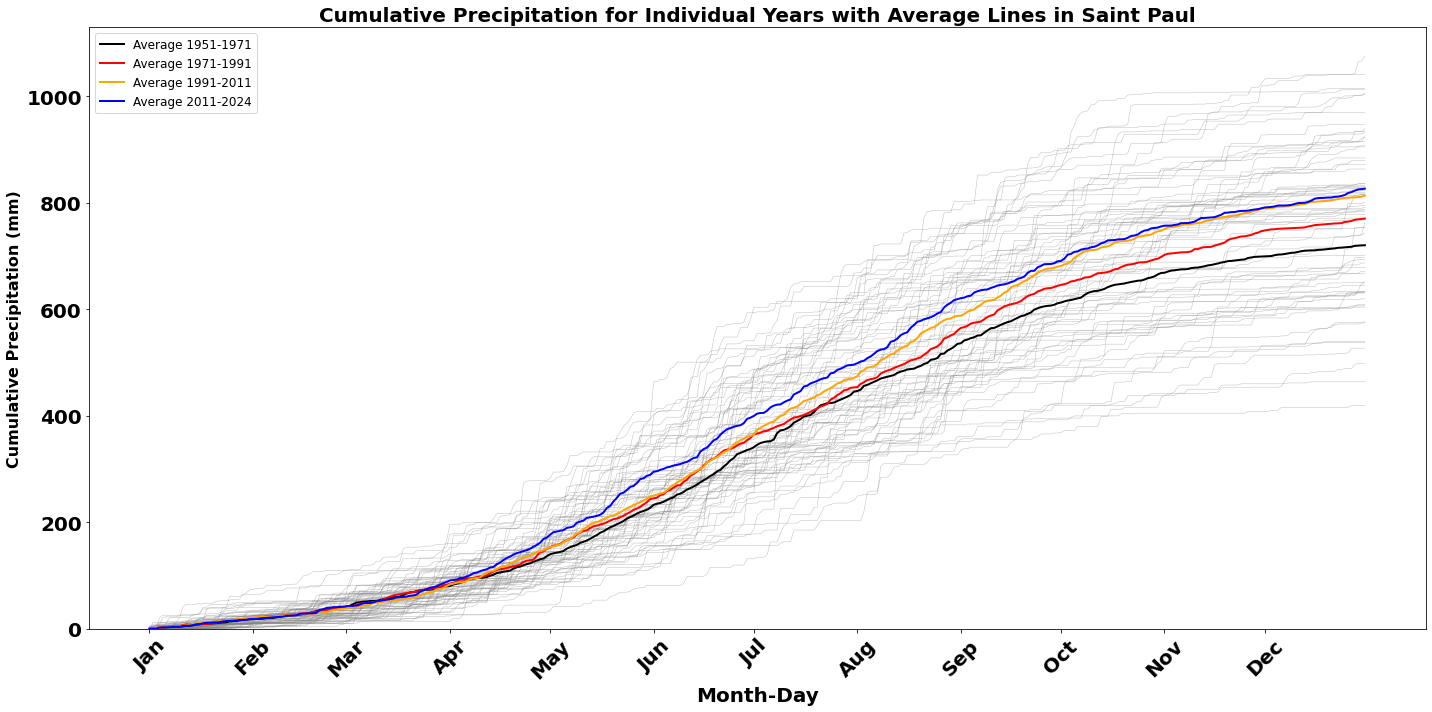

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import calendar

# Assuming 'data' DataFrame is already loaded with the necessary columns

# Initialize a figure
plt.figure(figsize=(20, 10))

# Convert 'time' to datetime format if it's not already
data['time'] = pd.to_datetime(data['time'])

# Create a 'Month_Day' column that ignores the year
data['Month_Day'] = data['time'].dt.strftime('%m-%d')

# Remove February 29th from the data to avoid leap year issues
data = data[~(data['Month_Day'] == '02-29')]

# Define colors for average lines
average_colors = ['black', 'red', 'orange', 'blue']

# Plot cumulative precipitation data for individual years
for year in data['time'].dt.year.unique():
    if year in [2000, 2016]:
        continue  # Skip the years 2000 and 2016
    year_data = data[data['time'].dt.year == year].copy()
    year_data['Cumulative_Precip'] = year_data['prcp'].cumsum()
    plt.plot(
        year_data['Month_Day'],
        year_data['Cumulative_Precip'],
        color='grey',
        alpha=0.5,
        linewidth=0.5
    )

# Define the periods for which we want to calculate the average cumulative precipitation
periods = [(1951, 1971), (1971, 1991), (1991, 2011), (2011, 2024)]

# Calculate and plot averages for defined periods
for (start_year, end_year), color in zip(periods, average_colors):
    period_data = data[(data['time'].dt.year >= start_year) & (data['time'].dt.year <= end_year)]
    period_data_grouped = period_data.groupby('Month_Day')['prcp'].mean().reset_index()
    period_data_grouped['Cumulative_Precip'] = period_data_grouped['prcp'].cumsum()
    plt.plot(
        period_data_grouped['Month_Day'],
        period_data_grouped['Cumulative_Precip'],
        label=f'Average {start_year}-{end_year}',
        color=color,
        linewidth=2
    )

# Set bold labels and title
plt.xlabel('Month-Day', fontsize=20, fontweight='bold')
plt.ylabel('Cumulative Precipitation (mm)', fontsize=16, fontweight='bold')
plt.title('Cumulative Precipitation for Individual Years with Average Lines in Saint Paul', fontsize=20, fontweight='bold')

# Bold tick labels
plt.xticks(fontsize=20, fontweight='bold', rotation=45)
plt.yticks(fontsize=20, fontweight='bold')

# Set the x-axis labels to show the first of each month
month_starts = [f'{i:02d}-01' for i in range(1, 13)]
plt.xticks(month_starts, [calendar.month_abbr[i] for i in range(1, 13)])

# Set the lower limit of y-axis to zero
plt.ylim(bottom=0)

# Add a legend
plt.legend(loc='upper left', fontsize=12)

# Adjust layout and save with 300 DPI
plt.tight_layout()
plt.savefig('Saint Paul cumulative_precipitation.png', dpi=300)

# Show plot
plt.show()

In [ ]:
import pandas as pd

# Ensure 'time' is in datetime format
data['time'] = pd.to_datetime(data['time'])

# Define R1, R5, R8 dates for 2023
r1_2023 = pd.Timestamp("2023-07-13")
r5_2023 = pd.Timestamp("2023-08-17")
r8_2023 = pd.Timestamp("2023-09-14")

# Define R1, R5, R8 dates for 2024
r1_2024 = pd.Timestamp("2024-07-25")
r5_2024 = pd.Timestamp("2024-09-05")
r8_2024 = pd.Timestamp("2024-09-26")

# Calculate precipitation sums for each interval
precip_2023_r1_r5 = data[(data['time'] >= r1_2023) & (data['time'] <= r5_2023)]['prcp'].sum()
precip_2023_r5_r8 = data[(data['time'] > r5_2023) & (data['time'] <= r8_2023)]['prcp'].sum()
precip_2023_r1_r8 = data[(data['time'] >= r1_2023) & (data['time'] <= r8_2023)]['prcp'].sum()

precip_2024_r1_r5 = data[(data['time'] >= r1_2024) & (data['time'] <= r5_2024)]['prcp'].sum()
precip_2024_r5_r8 = data[(data['time'] > r5_2024) & (data['time'] <= r8_2024)]['prcp'].sum()
precip_2024_r1_r8 = data[(data['time'] >= r1_2024) & (data['time'] <= r8_2024)]['prcp'].sum()

# Create a summary table
precip_summary = pd.DataFrame({
    'Year': [2023, 2023, 2023, 2024, 2024, 2024],
    'Stage': ['R1 to R5', 'R5 to R8', 'R1 to R8',
              'R1 to R5', 'R5 to R8', 'R1 to R8'],
    'Cumulative Precipitation (mm)': [
        precip_2023_r1_r5, precip_2023_r5_r8, precip_2023_r1_r8,
        precip_2024_r1_r5, precip_2024_r5_r8, precip_2024_r1_r8
    ]
})

print(precip_summary)


   Year     Stage  Cumulative Precipitation (mm)
0  2023  R1 to R5                     144.085938
1  2023  R5 to R8                       4.742188
2  2023  R1 to R8                     148.828125
3  2024  R1 to R5                     191.460938
4  2024  R5 to R8                      10.718750
5  2024  R1 to R8                     202.179688


/tmp/ipykernel_86/2943175897.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time'] = pd.to_datetime(data['time'])


In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv("Saintpaul_combined_data_NOAA.csv")
data['time'] = pd.to_datetime(data['time'])

# Define key dates for 2023
planting_2023 = pd.Timestamp("2023-05-18")
r1_2023 = pd.Timestamp("2023-07-13")
r5_2023 = pd.Timestamp("2023-08-17")
r8_2023 = pd.Timestamp("2023-09-14")

# Define key dates for 2024
planting_2024 = pd.Timestamp("2024-06-04")
r1_2024 = pd.Timestamp("2024-07-25")
r5_2024 = pd.Timestamp("2024-09-05")
r8_2024 = pd.Timestamp("2024-09-26")

# Calculate cumulative precipitation
# 2023
precip_2023_r1_r5 = data[(data['time'] >= r1_2023) & (data['time'] <= r5_2023)]['prcp'].sum()
precip_2023_r5_r8 = data[(data['time'] > r5_2023) & (data['time'] <= r8_2023)]['prcp'].sum()
precip_2023_plant_r8 = data[(data['time'] >= planting_2023) & (data['time'] <= r8_2023)]['prcp'].sum()

# 2024
precip_2024_r1_r5 = data[(data['time'] >= r1_2024) & (data['time'] <= r5_2024)]['prcp'].sum()
precip_2024_r5_r8 = data[(data['time'] > r5_2024) & (data['time'] <= r8_2024)]['prcp'].sum()
precip_2024_plant_r8 = data[(data['time'] >= planting_2024) & (data['time'] <= r8_2024)]['prcp'].sum()

# Build summary table
soybean_saintpaul_precip = pd.DataFrame({
    'Year': [2023, 2023, 2023, 2024, 2024, 2024],
    'Stage': ['R1 to R5', 'R5 to R8', 'Planting to R8'] * 2,
    'Cumulative Precipitation (mm)': [
        precip_2023_r1_r5, precip_2023_r5_r8, precip_2023_plant_r8,
        precip_2024_r1_r5, precip_2024_r5_r8, precip_2024_plant_r8
    ]
})

print(soybean_saintpaul_precip)


   Year           Stage  Cumulative Precipitation (mm)
0  2023        R1 to R5                     144.085938
1  2023        R5 to R8                       4.742188
2  2023  Planting to R8                     205.804688
3  2024        R1 to R5                     191.460938
4  2024        R5 to R8                      10.718750
5  2024  Planting to R8                     452.648438
